# Modeling with Bayesian Regression

Going the Bayesian Route - https://docs.pymc.io/notebooks/GLM-linear.html

In [1]:
# %load ../api_access_snippet.py
#import library
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials

#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

import pandas as pd 
import numpy as np

In [2]:
rush = read_file('rushing_data_model_ready')

## Quick Data Cleaning 

In [3]:
target = ['rush_fantasy_pts']
last_week = ['last_week_Yds', 'last_week_TD', 'last_week_rush_fantasy_pts']
inputs = ['yds_ratio', 'fantasy_pts_ratio', 'lag2_Yds', 'lag2_rush_fantasy_pts', 'lag2_TD']
rush = rush.replace('na', np.NaN);
fix_vars = target + last_week + inputs + ['Week']
rush[fix_vars] = rush[fix_vars].astype(float)
rush.loc[rush.rush_fantasy_pts < 0, 'rush_fantasy_pts'] = 0
rush['log1p_target'] = np.log1p(rush.rush_fantasy_pts + 1)
rush['yds_ratio'] = rush['yds_ratio'].fillna(0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].fillna(0)
rush['yds_ratio'] = rush['yds_ratio'].replace([np.inf, -np.inf], 0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].replace([np.inf, -np.inf], 0)

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px

plt.histogram(np.log1p(rush.last_week_rush_fantasy_pts)).show()

ModuleNotFoundError: No module named 'plotly'

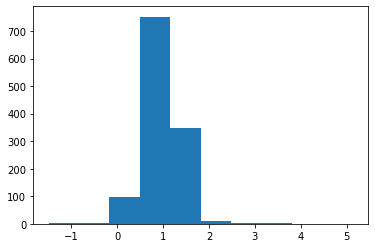

In [5]:
plt.hist(rush.yds_ratio);

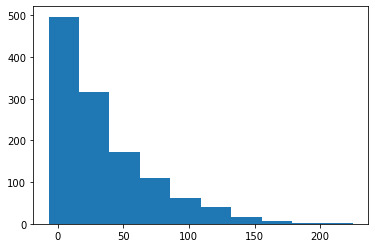

In [6]:
plt.hist(rush.last_week_Yds);

In [7]:
rush.Week.describe()

count    1223.000000
mean        8.921504
std         5.031201
min         1.000000
25%         4.000000
50%         9.000000
75%        13.000000
max        17.000000
Name: Week, dtype: float64

## Loading pymc3 and other packages

* https://docs.pymc.io/notebooks/posterior_predictive.html -- getting predictions 
* https://docs.pymc.io/notebooks/GLM-model-selection.html -- model selection, a long way off
* https://docs.pymc.io/notebooks/lasso_block_update.html -- ugh more attempts at this shit

In [8]:
import pymc3 as pm
#declaring model formulation
model_vars = ['log1p_target', 'last_week_rush_fantasy_pts', 'last_week_TD', 'last_week_Yds', 'yds_ratio', 'fantasy_pts_ratio', 'lag2_Yds', 'lag2_TD', 'lag2_rush_fantasy_pts']
f = 'log1p_target ~ np.log1p(last_week_rush_fantasy_pts) + last_week_TD + last_week_Yds + yds_ratio + fantasy_pts_ratio + lag2_Yds + lag2_TD + lag2_rush_fantasy_pts'
input_data = rush[model_vars].loc[rush['Week'] < 7, :]
score_data = rush[model_vars].loc[rush['Week'] == 7, :]

### Standard OLS

In [9]:
with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula(f, input_data, family=pm.glm.families.StudentT())
    trace = pm.sample(draws = 250, cores=4, init='adapt_diag', tune = 150)  # draw 700 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, lag2_rush_fantasy_pts, lag2_TD, lag2_Yds, fantasy_pts_ratio, yds_ratio, last_week_Yds, last_week_TD, np.log1p(last_week_rush_fantasy_pts), Intercept]


Sampling 4 chains for 250 tune and 750 draw iterations (1_000 + 3_000 draws total) took 234 seconds.
The acceptance probability does not match the target. It is 0.887702416286633, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
preds = pm.sample_posterior_predictive(trace, model=model, samples=1000)

C:\Users\chris\.julia\conda\3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


C:\Users\chris\.julia\conda\3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


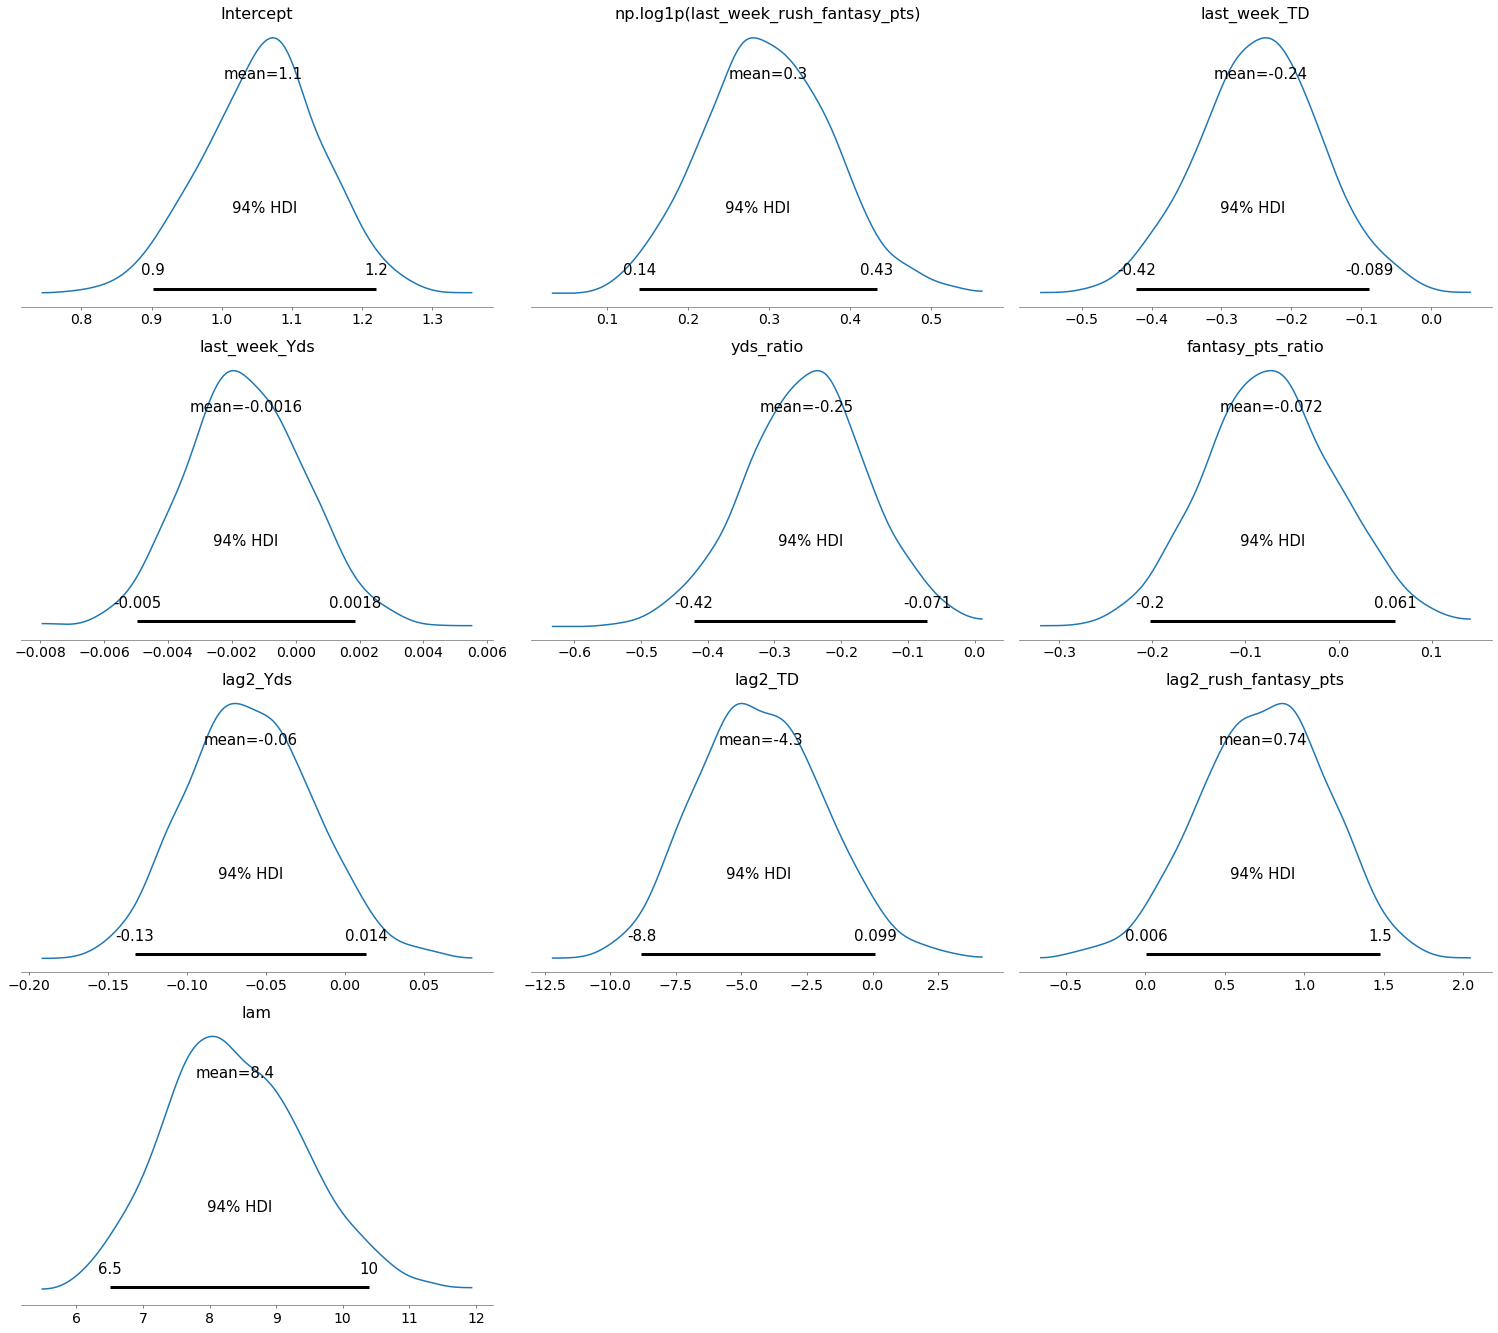

In [11]:
pm.plot_posterior(trace);

In [28]:
with model:
    pm.set_data({'data': score_data.to_numpy()})
    y_preds = pm.sample_posterior_predictive(trace)["p"]

KeyError: 'data'

In [30]:
with model:
    pm.set_data({'data': score_data.to_numpy()})
    trace

KeyError: 'data'

In [31]:
{'data': score_data.to_numpy()}

{'data': array([[ 1.85629799e+00,  1.32000000e+01,  0.00000000e+00,
          1.32000000e+02,  1.04693878e+00,  8.40983607e-01,
          8.55000000e+01,  0.00000000e+00,  8.55000000e+00],
        [ 2.72129543e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+01,  7.40506329e-01,  8.93939394e-01,
          5.85000000e+01,  5.00000000e-01,  8.85000000e+00],
        [ 3.33932198e+00,  1.01000000e+01,  1.00000000e+00,
          4.10000000e+01,  1.24759615e+00,  1.06554878e+00,
          8.65000000e+01,  5.00000000e-01,  1.16500000e+01],
        [ 1.88706965e+00,  1.12000000e+01,  1.00000000e+00,
          5.20000000e+01,  8.62275449e-01,  1.12891986e+00,
          4.80000000e+01,  1.00000000e+00,  1.08000000e+01],
        [ 1.80828877e+00,  1.71000000e+01,  2.00000000e+00,
          5.10000000e+01,  9.13636364e-01,  1.31571429e+00,
          3.35000000e+01,  2.00000000e+00,  1.53500000e+01],
        [ 2.83321334e+00,  2.80000000e+00,  0.00000000e+00,
          2.80000000e+01,  

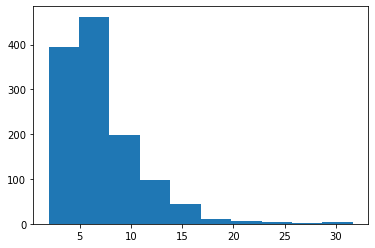

In [23]:
plt.hist(fit_df.fitted_value);

In [18]:
rush.columns

Index(['Name', 'Week', 'Opp', 'Score', 'Att', 'Yds', 'TD', 'FUM',
       'rush_fantasy_pts', 'total_fum', 'lag3_Yds', 'lag3_TD',
       'lag3_rush_fantasy_pts', 'lag2_Yds', 'lag2_TD', 'lag2_rush_fantasy_pts',
       'last_week_Yds', 'last_week_TD', 'last_week_rush_fantasy_pts',
       'yds_ratio', 'fantasy_pts_ratio', 'log1p_target'],
      dtype='object')

Text(0, 0.5, 'Rushing Fantasy Pts')

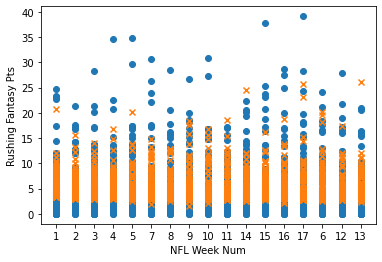

In [22]:
plt.subplots()
plt.scatter(rush.Week, rush.rush_fantasy_pts, label = 'obs rush pts', marker = 'o')
plt.scatter(rush.Week, y_pred, label = 'fitted values', marker = 'x')
plt.xlabel('NFL Week Num')
plt.ylabel('Rushing Fantasy Pts')

## Model Evaluation Tools 

In [ ]:
#creating function to loop through model building 
def build_model(formula, nfl_target_week, data, samples):
    input_data = data.loc[df['Week'] < nfl_target_week, :]
    score_data = data.loc[df['Week'] == nfl_target_week, :]
    y_obs = data.rush_fantasy_pts
    
    with pm.Model() as model:
        # specify glm and pass in data. The resulting linear model, its likelihood and
        # and all its parameters are automatically added to our model.
        pm.glm.GLM.from_formula(formula, input_data)
        trace = pm.sample(draws = samples, cores=4, init='adapt_diag') 
        
    #getting fitted values 
    ppc = pm.sample_posterior_predictive(score_data, model=model, samples=500)
    fit_array = np.mean(np.exp(np.asarray(ppc['y'])), axis = 0)
    fits = pd.DataFrame(fit_array, columns = ['fitted_value'])
    
    #getting fit delta and calculating difference 
    delta = y_obs - fits 
    rmse = np.sqrt(delta**2)
    
    #output list 
    model_info = (trace, rmse)